# SMCF Test
## SMCF Calculation and MU
## SMCF evaluation for Color Sensors

In [ ]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs, plot_color_data
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict
from luxpy.spectrum import spd_to_xyz

from empir19nrm02 import _SPD, _RES
from empir19nrm02.tools.help import display_color_diagram, display_spectra

print('Version of luxpy:', lx.__version__)
out_dir = 'SMCF_Test'

import os
print( 'CWD:', os.getcwd())

Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


XDetectors


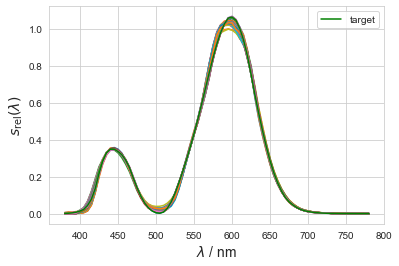

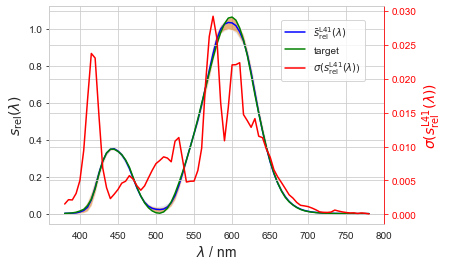

[4.0279e-07 4.6475e-02 3.6214e-02 3.8050e-02 3.7328e-02 3.9067e-02
 3.9621e-02 4.1052e-02 5.0117e-02 3.9913e-02 3.0391e-02 3.3855e-02
 4.3979e-02 3.3693e-02 3.1888e-02 3.0635e-02 3.0851e-02 2.8535e-02
 3.1285e-02 3.3651e-02 3.1627e-02 3.0915e-02 1.1936e-02 1.0980e-02
 1.0880e-02 1.1019e-02 1.0613e-02]


In [ ]:
_name = 'XDetectors'
_detectors=_RES[_name]['S']['data'].copy()
XNorm, f1pX = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=1, out_dir=out_dir)

YDetectors


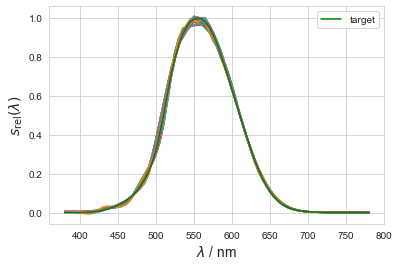

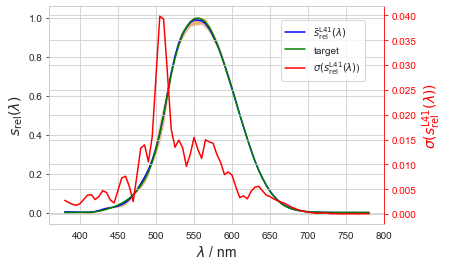

[0.0000e+00 3.2784e-02 2.2070e-02 2.1332e-02 2.1262e-02 2.5198e-02
 2.6587e-02 2.5145e-02 2.9574e-02 2.2676e-02 2.4612e-02 2.2251e-02
 3.6829e-02 3.3852e-02 3.1918e-02 3.0365e-02 3.1313e-02 3.1210e-02
 2.2501e-02 2.2689e-02 2.3784e-02 2.7327e-02 7.5231e-03 8.1952e-03
 7.4113e-03 8.3398e-03 7.9245e-03]


In [ ]:
_name = 'YDetectors'
_detectors=_RES[_name]['S']['data'].copy()
YNorm, f1pY = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=2, out_dir=out_dir)

ZDetectors


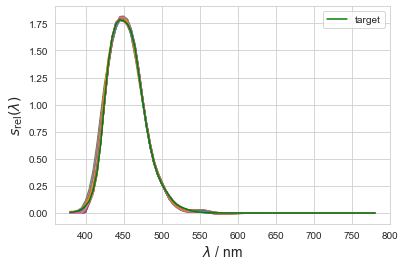

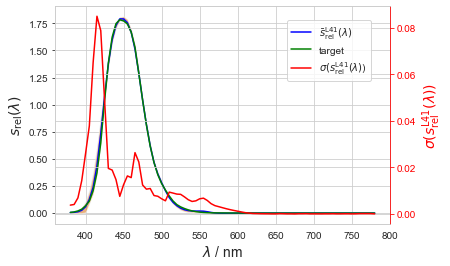

[2.4322e-12 2.7408e-02 2.4510e-02 2.4638e-02 2.7551e-02 2.1452e-02
 2.1966e-02 2.1445e-02 2.4163e-02 2.8351e-02 2.5515e-02 2.4951e-02
 7.0998e-02 6.0804e-02 6.1764e-02 5.5268e-02 5.6484e-02 5.4493e-02
 1.9811e-02 2.2649e-02 2.4050e-02 3.7207e-02 1.8671e-02 2.0420e-02
 1.9229e-02 2.1217e-02 1.7124e-02]


In [ ]:
_name = 'ZDetectors'
_detectors=_RES[_name]['S']['data'].copy()
ZNorm, f1pZ = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=3, out_dir=out_dir)

In [ ]:
detectors_color = np.zeros((3,XNorm.shape[0], XNorm.shape[1]))
detectors_color[0] = XNorm.copy()
detectors_color[1] = YNorm.copy()
detectors_color[2] = ZNorm.copy()


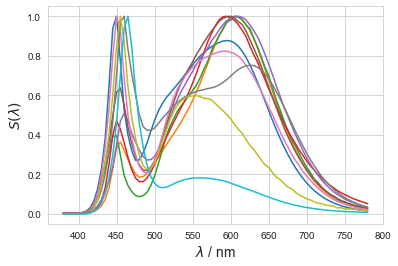

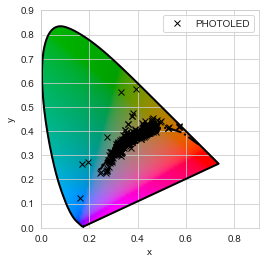

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

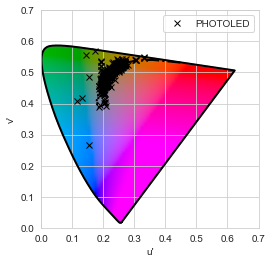

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#spd = 'MONOLED'
spd = 'PHOTOLED'

_spectra=lx.cie_interp( _SPD[spd]['S']['data'], wl_new=detectors_color[0,0,:], kind = 'S')

display_spectra( spd, _spectra, curvenumber=10)
save_fig(out_dir, spd + '_spectra')

display_color_diagram(spd, _spectra,cspace='Yxy')
save_fig(out_dir, spd + '_xy')

display_color_diagram(spd, _spectra,cspace='Yuv76')
save_fig(out_dir, spd + '_uv76')

In [ ]:
SMCF_A = np.zeros((3,_spectra.shape[0]-1, detectors_color.shape[1]-1))
SMCF_L41 = np.zeros((3,_spectra.shape[0]-1, detectors_color.shape[1]-1))
for i in range(3):
    SMCF_A[i]=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, detectors_color[i], S_C='LED_B3', cieobs='1931_2', s_target_index=i+1)
    SMCF_L41[i]=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, detectors_color[i], S_C='LED_L41', cieobs='1931_2', s_target_index=i+1)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def SMCF_plot( _smcfData, calib='A', name='SMCF'):
    fig, ax1 = pyplot.subplots(figsize=(7,7))
    im1 = ax1.imshow(_smcfData, aspect='auto',
                    #extent=[wl_scale[0], wl_scale[-1], wl_scale[-1], wl_scale[0]],
                    cmap="jet", interpolation="nearest")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_title(name)
    ax1.set_xlabel('Detector#', fontsize=label_font_size)
    ax1.set_ylabel('SD#', fontsize=label_font_size)

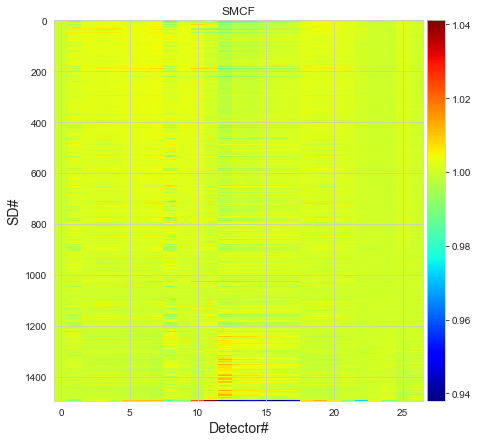

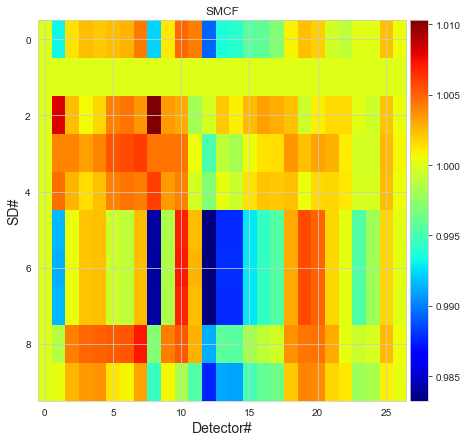

In [ ]:
SMCF_plot(SMCF_A[0], calib='A', name='SMCF')
SMCF_plot(SMCF_A[0][0:10, :], calib='A', name='SMCF')
save_fig(out_dir, 'SMCF_img')

In [ ]:
channels = detectors_color.shape[0]
# 0 is the wavellength scale, 1 is the ideal detector
detectorItem = 2
# 0 is the wavelenght scale, 1 is StdIllA, 2 is L41
SDItem = 10

if detectorItem == 0 or SDItem == 0:
    print( 'Error # 0 is not a detector or SD. This is the wavelength scale')

#calibSD = 'A'
calibSD = 'LED_L41'
SMCFColor = np.zeros(channels)

for i in range( channels):
    SMCFColor[i]=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
        np.vstack( (_spectra[0], _spectra[SDItem])),
        np.vstack( (detectors_color[i, 0], detectors_color[i, detectorItem])),
        S_C=calibSD, cieobs='1931_2', s_target_index=i+1)

print( SMCFColor)

[1.0003e+00 9.9565e-01 9.9520e-01]


In [ ]:
from empir19nrm02.tools import plot_2D
from luxpy import SPD
from empir19nrm02.MC.MCSim import MCVectorVar, McInputVar, McOutputVar, NameUnit, DistributionParam, McOutputVar, McSim, McSpectrumVar, noise_list_default
from empir19nrm02.tools import sumMC

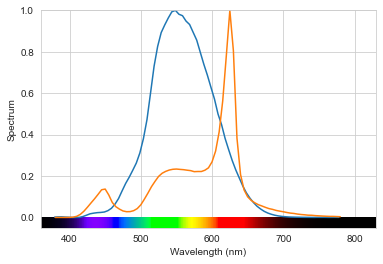

In [20]:
SMCF = McOutputVar(name=NameUnit('SMCF', '1'))
NumberTrials = 1000
ch = 1
detectorSPD = lx.SPD( spd=np.vstack((detectors_color[ch, 0], detectors_color[ch, detectorItem])/np.max(detectors_color[ch, detectorItem])),ax0iswl=True)
spectrumSPD = lx.SPD( spd=np.vstack((_spectra[0], _spectra[SDItem]/np.max(_spectra[SDItem]))),ax0iswl=True)

detectorSPD.plot()
spectrumSPD.plot()
save_fig(out_dir, 'Sample_Distribution')

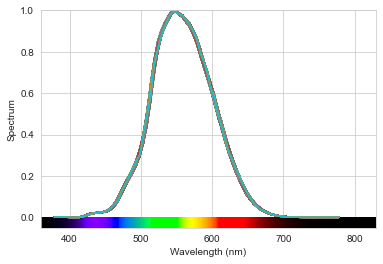

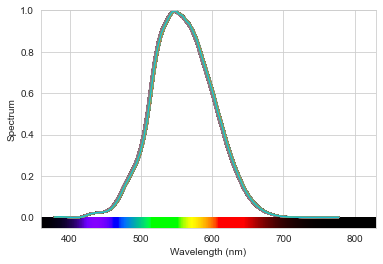

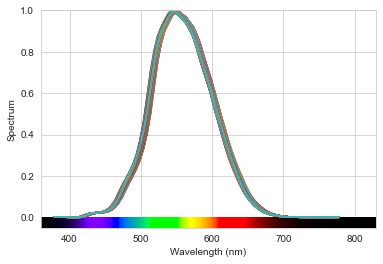

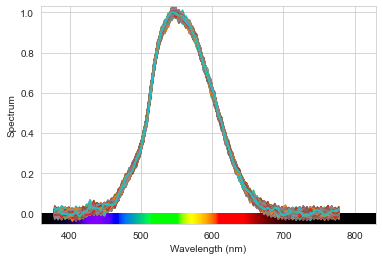

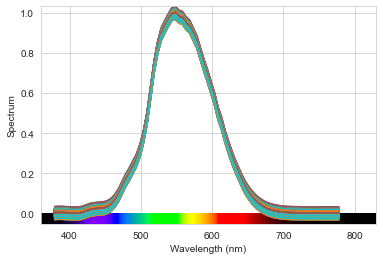

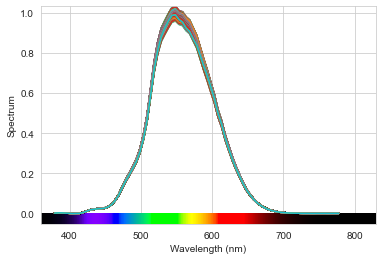

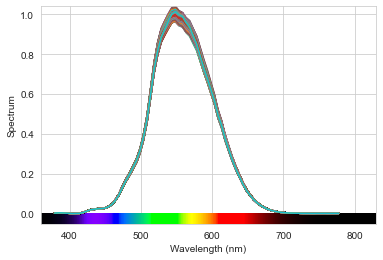

wl_nc (1.004523030597979, 0.0022212755777592606)
wl_c (1.0045975821729878, 0.0058773870065363535)
wl_f [1.0044e+00] [7.3318e-03]
v_nc (1.0045692515451556, 0.0023464052761100855)
v_c (1.0045651378271487, 0.0010291182127420326)
v_f [1.0046e+00] [1.5398e-03]
all (1.004640768941773, 0.0015122398819792712)


In [21]:
def runSimpleMC( detectorMC, SMCF, NumberTrials, model_single):
    input = [detectorMC]
    output = [SMCF]

    sim = McSim(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_single)
    return sim.output_var


petriNumbers = 40
uSMCF = np.zeros(petriNumbers)
mSMCF = np.zeros(petriNumbers)


simulationResult = {}
for key in noise_list_default:
    if '_f' in key:
        simulationResult[key] =  [ np.zeros(petriNumbers), np.zeros(petriNumbers)]
    else:
        simulationResult[key] =  [0., 0.]


detectorList = list()

def model_single(detector):
    # for test only
    global  ch
    # implementation
    detectorList.append( detector)
    spectmp = np.vstack( (spectrumSPD.wl, spectrumSPD.value) )
    detectortmp = np.vstack( (detector.wl, detector.value) )
    SMCF = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
                        spectmp, detectortmp, S_C=calibSD, cieobs='1931_2', s_target_index=ch+1)
    # Vektoren gehen noch nicht als Rückgabe
    return [SMCF]
def plot_dist( key):

    t = np.zeros((len(detectorList)+1, detectorList[0].shape[1]))
    t[0] = detectorList[0].wl
    for i in range(len(detectorList)):
        t[i+1] = detectorList[i].value
    SPD(spd=t).plot()
    save_fig(out_dir, 'MCDistribution_' + key)

for key in simulationResult:
    detectorList.clear()
    if '_f' in key:
        for petriNumber in range(7, 8):
            match key:
                case 'wl_f':  noise_list = { key: DistributionParam(mean=0, stddev=1, add_params=petriNumber)}
                case 'v_f':   noise_list = { key: DistributionParam(mean=0, stddev=0.01, add_params=petriNumber)}
            detectorMC = McSpectrumVar( name = NameUnit('Detector', 'A.U.'), spd= detectorSPD, noise_list=noise_list)
            out = runSimpleMC( detectorMC, SMCF, NumberTrials, model_single)
            simulationResult[key][0][petriNumber] = np.mean(out[0][0].val)
            simulationResult[key][1][petriNumber] = np.std(out[0][0].val)
            plot_dist( key)

    else:
        match key:
            case 'wl_nc': noise_list = { key: DistributionParam(mean=0, stddev=1, distribution='uniform')}
            case 'wl_c':  noise_list = { key: DistributionParam(mean=0, stddev=1, distribution='uniform')}
            case 'v_nc':  noise_list = { key: DistributionParam(mean=0, stddev=0.01)}
            case 'v_c':   noise_list = { key: DistributionParam(mean=0, stddev=0.01)}

        detectorMC = McSpectrumVar( name = NameUnit('Detector', 'A.U.'), spd= detectorSPD, noise_list=noise_list)
        out = runSimpleMC( detectorMC, SMCF, NumberTrials, model_single)

        simulationResult[key] = ( np.mean(out[0][0].val), np.std(out[0][0].val))
        plot_dist( key)

for key in simulationResult:
    if not '_f' in key:
        print( key, simulationResult[key])
    else:
        pos = np.where(simulationResult[key][1] == np.max(simulationResult[key][1]))
        print( key, simulationResult[key][0][pos[0]], simulationResult[key][1][pos[0]])

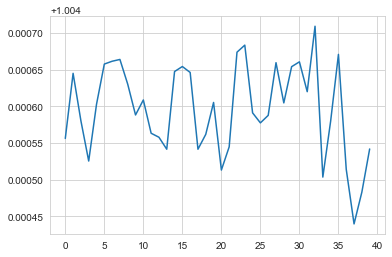

In [ ]:
pyplot.plot(simulationResult['wl_f'][0])

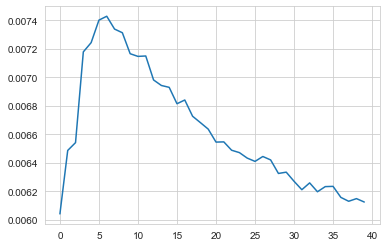

In [ ]:
pyplot.plot(simulationResult['wl_f'][1])
save_fig(out_dir, 'wl_f')

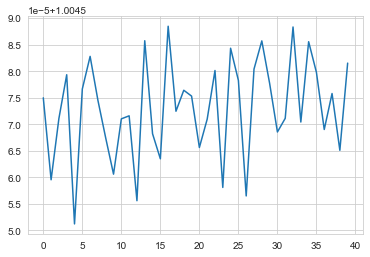

In [ ]:
pyplot.plot(simulationResult['v_f'][0])

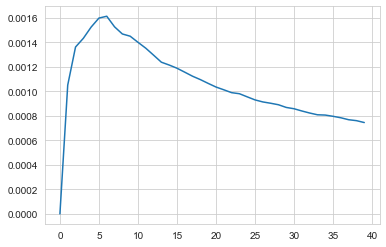

In [ ]:
pyplot.plot(simulationResult['v_f'][1])
save_fig(out_dir, 'v_f')

In [ ]:
break

SyntaxError: 'break' outside loop (370545404.py, line 1)

In [ ]:
SMCF_out = MCVectorVar( name=NameUnit('SMCF', '1'), elements=3)
SMCF_X = McOutputVar(name=NameUnit('SMCFX', '1'))
SMCF_Y = McOutputVar(name=NameUnit('SMCFY', '1'))
SMCF_Z = McOutputVar(name=NameUnit('SMCFZ', '1'))
SMCF_2 = MCVectorVar(name=NameUnit('SMCF_2', '1'), elements=2)

NumberTrials = 300
ch = 1

print(detectors_color[ch, detectorItem].shape)
print(detectors_color[ch, 0].shape)
# Bug in luxpy while spd is only a one spectrum and spd and wl is set separately
detectorMC = list()
for i in range( channels):
    detectorSPD = lx.SPD( spd=np.vstack((detectors_color[i, 0], detectors_color[i, detectorItem])),ax0iswl=True)
    match i:
        case 0: detName = 'DetectorX'
        case 1: detName = 'DetectorY'
        case 2: detName = 'DetectorZ'

    detectorMC.append( McSpectrumVar( name = NameUnit(detName, 'A.U.'), spd= detectorSPD,
        noise_list ={
        #'wl_nc': DistributionParam(mean=0, stddev=1, distribution='uniform'),
        #'wl_c': DistributionParam(mean=0, stddev=10, distribution='uniform'),
        #'wl_f': DistributionParam(mean=0, stddev=1, add_params=4),
        #'v_nc': DistributionParam(mean=0, stddev=0.01),
        #'v_c': DistributionParam(mean=0, stddev=0.01),
        #'v_f': DistributionParam(mean=0, stddev=0.01, add_params=4),
        #'all': None
        }))

spectrumSPD = lx.SPD( spd=np.vstack((_spectra[0], _spectra[SDItem])),ax0iswl=True)
spectrumMC = McSpectrumVar( name = NameUnit('SD', 'A.U.'), spd = spectrumSPD,
    noise_list ={
    #'wl_nc': DistributionParam(mean=0, stddev=1, distribution='uniform'),
    #'wl_c': DistributionParam(mean=0, stddev=10, distribution='uniform'),
    #'wl_f': DistributionParam(mean=0, stddev=1, add_params=4),
    #'v_nc': DistributionParam(mean=0, stddev=0.01),
    #'v_c': DistributionParam(mean=0, stddev=0.01),
    'v_f': DistributionParam(mean=0, stddev=0.01, add_params=4),
    #'all': None
    })


specList = list()
detectorList = list()
for i in range(channels):
    detectorList.append(list())

modelCount = 0

def model_t1(x1):
    global  modelCount
    print('model_t:', modelCount, x1)
    modelCount += 1
    return [x1]

def model_t2(x1, x2):
    global  modelCount
    print('model_t:', modelCount, x1, x2)
    modelCount += 1
    return [x1, x2]

def model_t(x1, x2, x3, x4):
    global  modelCount
    print('model_t:', modelCount, x1, x2, x3, x4)
    modelCount += 1
    return [x1]

def model(spec, detectorX, detectorY, detectorZ):
    # for test only
    global  modelCount
    #print(modelCount)
    modelCount += 1
    specList.append( spec)
    for i in range(channels):
        match i:
            case 0: detectorList[i].append( detectorX)
            case 1: detectorList[i].append( detectorY)
            case 2: detectorList[i].append( detectorZ)

    # implementation
    spectmp = np.vstack( (spec.wl, spec.value) )
    SMCF = np.zeros(3)
    for i in range( channels):
        match i:
            case 0: detectortmp = np.vstack( (detectorX.wl, detectorX.value) )
            case 1: detectortmp = np.vstack( (detectorY.wl, detectorY.value) )
            case 2: detectortmp = np.vstack( (detectorZ.wl, detectorZ.value) )
        SMCF[i] = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
                        spectmp, detectortmp, S_C=calibSD, cieobs='1931_2', s_target_index=i+1)
    # Vektoren gehen noch nicht als Rückgabe
    return [SMCF[0], SMCF[1], SMCF[2], [SMCF[0], SMCF[1]]]

input = [spectrumMC, detectorMC[0], detectorMC[1], detectorMC[2]]
output = [SMCF_X, SMCF_Y, SMCF_Z, SMCF_2]

sim = McSim(trials=NumberTrials)
sim.set_input_var(input)
sim.set_output_var(output)
sim.generate()

#sim.calculate_model(model)
sim.calculate_model(model)

for i in range(len(input)+1):
    print( i)
    for var in sim.output_var[i]:
        var.print_stat()

print(len(specList))
t = np.zeros((len(specList)+1, specList[0].shape[1]))
t[0] = specList[0].wl
t1 = np.zeros((channels, len(detectorList[0])+1, detectorList[0][0].shape[1]))
for ii in range( channels):
    t1[ii][0] = detectorList[0][0].wl
    for i in range(len(specList)):
        t[i+1] = specList[i].value
        t1[ii][i+1] = detectorList[ii][i].value
tmpSPD = SPD(spd=t)

In [ ]:
plot_2D(sim.output_var[4][3])

In [ ]:
tmpSPD.plot()

In [ ]:
SPD(spd=t1[0]).plot()

In [ ]:
SPD(spd=t1[1]).plot()

In [ ]:
SPD(spd=t1[2]).plot()